# Configuración

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# CSV a tratar

In [2]:
import pandas as pd
malicious_data = pd.read_csv("1000sampling.csv")
non_malicious_data = pd.read_csv("Traficobueno1000.csv")

# Limpieza de características

In [3]:
#Elimina datos
columnas_a_eliminar = ['srcaddr','dstaddr','exaddr','engine_type','engine_id','dst_mask','src_mask', 'dst_mask','src_as','dst_as','#:unix_secs','unix_nsecs','sysuptime','first','last','nexthop']
malicious_data = malicious_data.drop(columnas_a_eliminar, axis=1)
non_malicious_data = non_malicious_data.drop(columnas_a_eliminar, axis=1)

In [4]:
malicious_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   dpkts      804 non-null    int64
 1   doctets    804 non-null    int64
 2   input      804 non-null    int64
 3   output     804 non-null    int64
 4   srcport    804 non-null    int64
 5   dstport    804 non-null    int64
 6   prot       804 non-null    int64
 7   tos        804 non-null    int64
 8   tcp_flags  804 non-null    int64
dtypes: int64(9)
memory usage: 56.7 KB


In [5]:
non_malicious_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   dpkts      804 non-null    int64
 1   doctets    804 non-null    int64
 2   input      804 non-null    int64
 3   output     804 non-null    int64
 4   srcport    804 non-null    int64
 5   dstport    804 non-null    int64
 6   prot       804 non-null    int64
 7   tos        804 non-null    int64
 8   tcp_flags  804 non-null    int64
dtypes: int64(9)
memory usage: 56.7 KB


# Clasificación


In [6]:

# Agregar una columna de etiquetas a cada conjunto de datos
malicious_data['etiqueta'] = 1
non_malicious_data['etiqueta'] = 0
# Combinar los conjuntos de datos y mezclarlos aleatoriamente
datos = pd.concat([malicious_data, non_malicious_data]).sample(frac=1, random_state=2)

X = datos.drop('etiqueta', axis=1)
y = datos['etiqueta']
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

from sklearn.preprocessing import MinMaxScaler
# Inicializa el escalador
scaler = MinMaxScaler()

# Ajusta el escalador a los datos de entrenamiento y luego transforma los datos de entrenamiento
X_train = scaler.fit_transform(X_train)

# Usa el escalador ajustado para transformar los datos de prueba
X_test = scaler.transform(X_test)



In [7]:
def evaluate_classification_model_no_cv(model, algorithm_name):
    # Entrenar el modelo y medir el tiempo de entrenamiento
    start_time_train = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time_train

    # Realizar predicciones con el modelo y medir el tiempo de predicción
    start_time_predict = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time_predict

    # Calcular las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Crear un DataFrame con los resultados y tiempos
    results_df = pd.DataFrame({
        'Algorithm': [algorithm_name],
        'Accuracy': [accuracy],
        'Recall': [recall],
        'Precision': [precision],
        'F1 Score': [f1],
        'Training Time (s)': [training_time],
        'Prediction Time (s)': [predict_time]
    })

    # Imprimir los resultados
    print('Results for', algorithm_name)
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1 Score:', f1)
    print('Training Time (s):', training_time)
    print('Prediction Time (s):', predict_time)

    # Imprimir matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No malicioso", "Malicioso"])
    
    # Dibujar la matriz de confusión
    fig, ax = plt.subplots(figsize=(5, 5))
    cmd.plot(ax=ax, cmap=plt.cm.Blues)
    plt.show()
    plt.close()

    return results_df

In [8]:
# Función para evaluar el modelo con CV
def evaluate_classification_model_with_cv(model, X_test, y_test, cv=5):
    # Realiza la validación cruzada y obtén las predicciones
    y_pred = cross_val_predict(model, X_test, y_test, cv=cv)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy del modelo con CV: {:.2f}%'.format(accuracy * 100))
    
    # Recall
    recall = recall_score(y_test, y_pred)
    print('Recall con CV: {:.2f}%'.format(recall * 100))
    
    # Precisión
    precision = precision_score(y_test, y_pred)
    print('Precisión con CV: {:.2f}%'.format(precision * 100))
    
    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print('F1 Score con CV: {:.2f}%'.format(f1 * 100))

    # Imprimir matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No malicioso", "Malicioso"])
    
    # Dibujar la matriz de confusión
    fig, ax = plt.subplots(figsize=(5, 5))
    cmd.plot(ax=ax, cmap=plt.cm.Blues)
    plt.show()



In [9]:
# Crear un diccionario para almacenar los resultados de los algoritmos
results = {}

In [10]:
def save_results_to_csv(results, csv_file):
    with open(csv_file, 'w') as f:
        f.write('Algorithm,Accuracy,Recall,Precision,F1 Score,Training Time (s),Prediction Time (s)\n')
        for algorithm, df in results.items():
            for _, row in df.iterrows():
                f.write(f"{algorithm},{row['Accuracy']},{row['Recall']},{row['Precision']},{row['F1 Score']},"
                        f"{row['Training Time (s)']},{row['Prediction Time (s)']}\n")


# KNeighbors

In [11]:
modelKNN = KNeighborsClassifier()

Results for KNN
Accuracy: 0.9751552795031055
Recall: 0.9685534591194969
Precision: 0.9808917197452229
F1 Score: 0.9746835443037974
Training Time (s): 0.0019998550415039062
Prediction Time (s): 0.00900125503540039


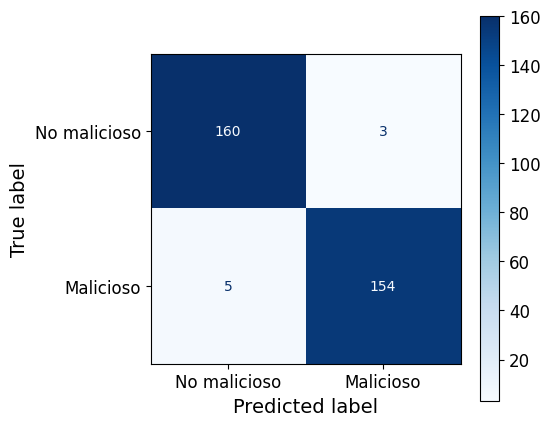

In [12]:
# Evaluación sin CV
results["KNN"] = evaluate_classification_model_no_cv(modelKNN,"KNN")

In [13]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelKNN, X_test, y_test, cv=5)

# LogisticRegression

In [14]:
modelLR = LogisticRegression()

Results for LR
Accuracy: 0.8416149068322981
Recall: 0.7044025157232704
Precision: 0.9655172413793104
F1 Score: 0.8145454545454546
Training Time (s): 0.017999887466430664
Prediction Time (s): 0.0


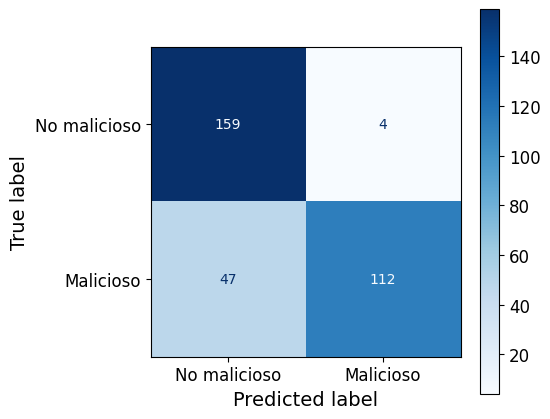

In [15]:
# Evaluación sin CV
results["LR"] = evaluate_classification_model_no_cv(modelLR,"LR")

In [16]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelLR, cv=5)

# SVC

In [17]:
modelSVC = LinearSVC()

Results for SVC
Accuracy: 0.8850931677018633
Recall: 0.7924528301886793
Precision: 0.9692307692307692
F1 Score: 0.8719723183391004
Training Time (s): 0.001998424530029297
Prediction Time (s): 0.0


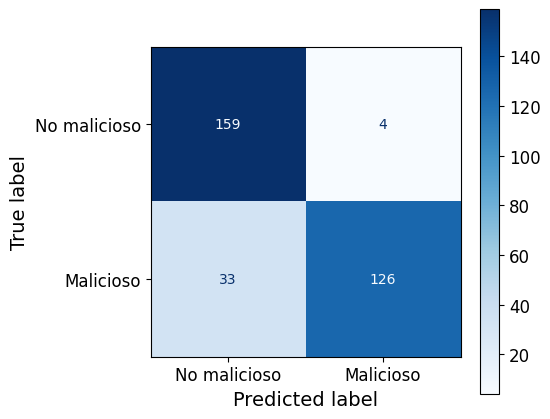

In [18]:
# Evaluación sin CV
results["SVC"] = evaluate_classification_model_no_cv(modelSVC,"SVC")

In [19]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelSVC, X_test, y_test, cv=5)

# RandomForestClassifier

In [20]:
modelRF = RandomForestClassifier()

Results for RF
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Training Time (s): 0.10499954223632812
Prediction Time (s): 0.007002353668212891


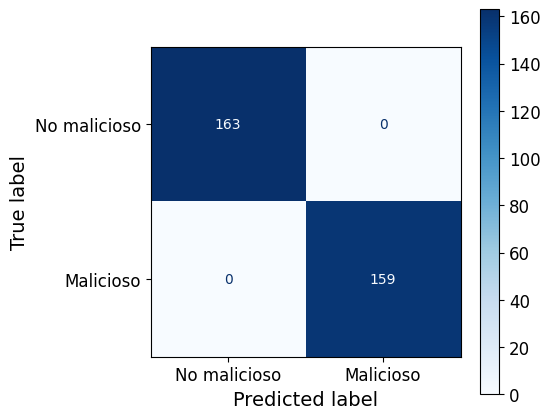

In [21]:
# Evaluación sin CV
results["RF"] = evaluate_classification_model_no_cv(modelRF,"RF")

In [22]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelRF, X_test, y_test, cv=5)

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
# Crear el modelo de árbol de decisión
modelDT = DecisionTreeClassifier()


Results for DT
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Training Time (s): 0.0010013580322265625
Prediction Time (s): 0.0


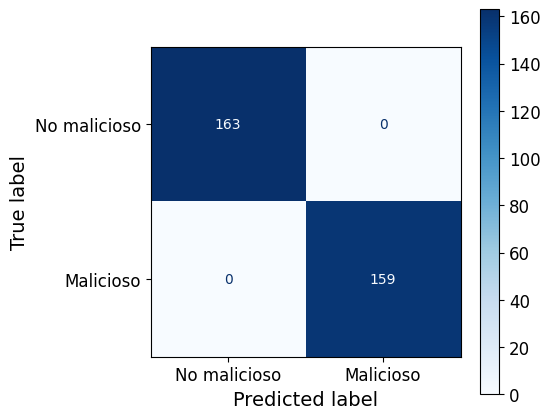

In [24]:
# Evaluación sin CV
results["DT"] = evaluate_classification_model_no_cv(modelDT,"DT")

In [25]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelDT, X_test, y_test, cv=5)

# XGBoost

In [26]:
import xgboost as xgb
# Crear el modelo XGBoost
modelXGB = xgb.XGBClassifier()


Results for XGB
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
Training Time (s): 0.055999040603637695
Prediction Time (s): 0.0010004043579101562


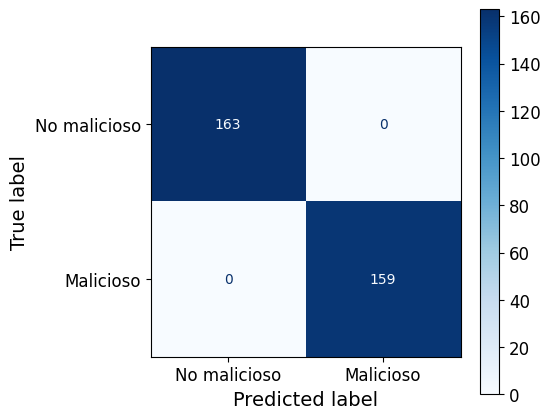

In [27]:
# Evaluación sin CV
results["XGB"] = evaluate_classification_model_no_cv(modelXGB,"XGB")

In [28]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelXGB, X_test, y_test, cv=5)

# Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB
modelNB = GaussianNB()

Results for NB
Accuracy: 0.7950310559006211
Recall: 1.0
Precision: 0.7066666666666667
F1 Score: 0.828125
Training Time (s): 0.0010044574737548828
Prediction Time (s): 0.0


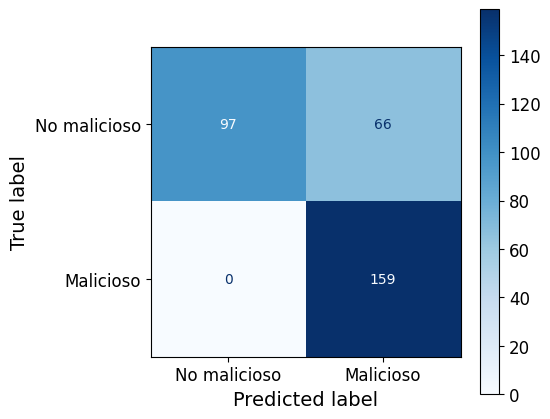

In [30]:
# Evaluación sin CV
results["NB"] = evaluate_classification_model_no_cv(modelNB,"NB")

In [31]:
# Evaluación con CV
#evaluate_classification_model_with_cv(modelNB, X_test, y_test, cv=5)

# Ensemble Classifier con votación mayoritaria para mejorar la precisión

Results for Ensemble
Accuracy: 0.9906832298136646
Recall: 1.0
Precision: 0.9814814814814815
F1 Score: 0.9906542056074767
Training Time (s): 0.1550002098083496
Prediction Time (s): 0.02499985694885254


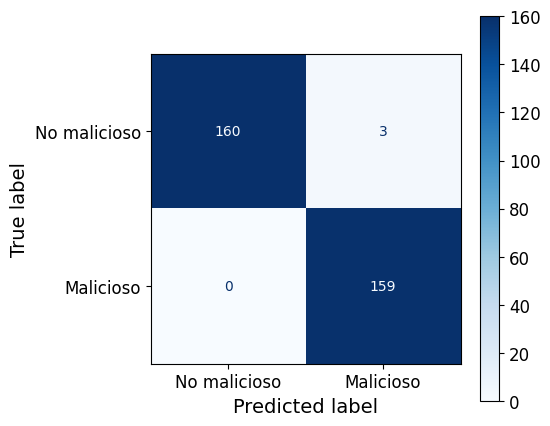

In [32]:
from sklearn.ensemble import VotingClassifier
# Crear el ensemble classifier con votación mayoritaria
ensemble_model = VotingClassifier(estimators=[('KNN', modelKNN),('LR', modelLR), ('SVC', modelSVC), ('RF', modelRF),('DT', modelDT), ('XGB', modelXGB),('NB', modelNB)], voting='hard')
ensemble_model.fit(X_train, y_train)
results["Ensemble"] = evaluate_classification_model_no_cv(ensemble_model,"Ensemble")


In [33]:
# Guardar los resultados en un archivo de Excel
csv_file = 'resultados_algoritmos_sampling.csv'
save_results_to_csv(results, csv_file)

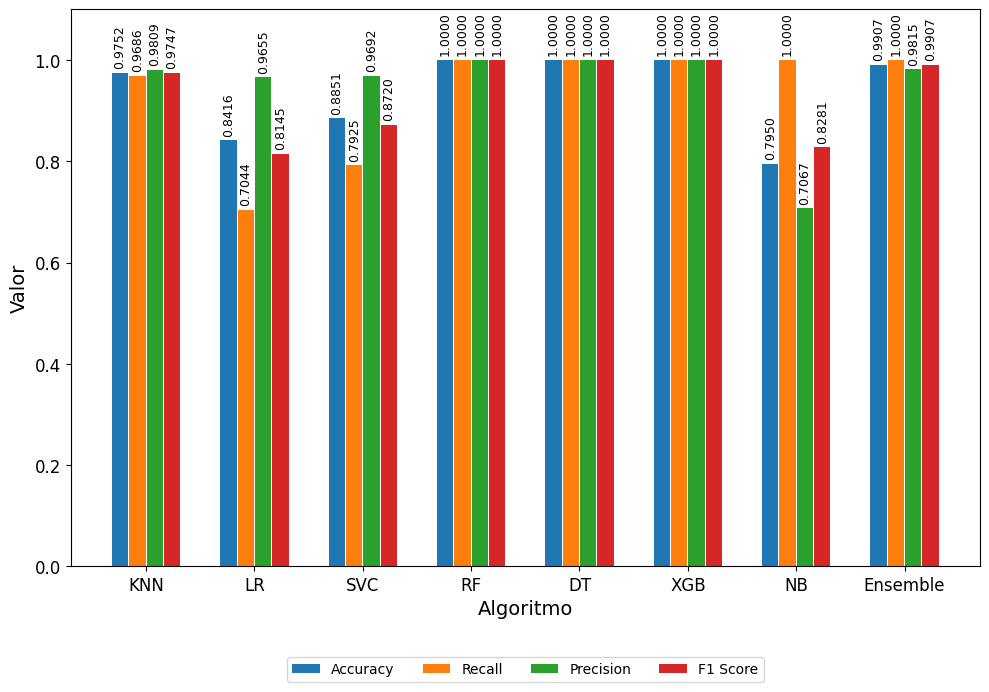

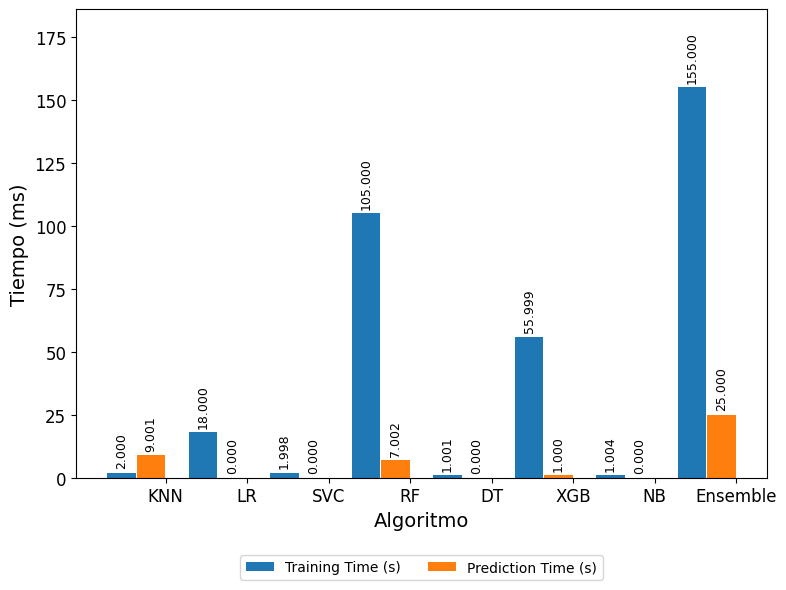

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer el archivo CSV con los resultados
results_df = pd.read_csv('resultados_algoritmos_sampling.csv')

# Gráfico de barras para las métricas de evaluación
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
algorithms = results_df['Algorithm']
data = results_df[metrics].values

fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.15
group_spacing = 0.01  # Espacio entre grupos de barras
x = np.arange(len(algorithms))

bars = []
for i, metric in enumerate(metrics):
    bar = ax.bar(x + (i - 1.5) * (bar_width + group_spacing), data[:, i], bar_width, label=metric)
    bars.append(bar)

ax.set_xlabel('Algoritmo')
ax.set_ylabel('Valor')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(metrics))

# Agregar etiquetas a las barras
for bar in bars:
    ax.bar_label(bar, label_type='edge', fontsize=9, fmt='%.4f', rotation=90, padding=3)

# Ajustar los márgenes verticales
plt.ylim(top=data.max() * 1.1)

plt.tight_layout()
plt.show()

# Gráfico de barras para los tiempos de entrenamiento y predicción en ms
time_metrics = ['Training Time (s)', 'Prediction Time (s)']
time_data = results_df[time_metrics].values * 1000  # Multiplicar por 1000 para convertir a ms

fig, ax = plt.subplots(figsize=(8, 6))
# Utilizando el mismo bar_width y group_spacing
bar_width = 0.35
group_spacing = 0.01

bars = []
for i, time_metric in enumerate(time_metrics):
    bar = ax.bar(x + (i - 1.5) * (bar_width + group_spacing), time_data[:, i], bar_width, label=time_metric)
    bars.append(bar)

ax.set_xlabel('Algoritmo')
ax.set_ylabel('Tiempo (ms)')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(time_metrics))

# Agregar etiquetas a las barras
for bar in bars:
    ax.bar_label(bar, label_type='edge', fontsize=9, fmt='%.3f', rotation=90, padding=3)

# Ajustar los márgenes verticales
plt.ylim(top=max(time_data.max() * 1.2, 1))

plt.tight_layout()
plt.show()







